In [1]:
from CoLoRe_corrf_analysis.plot_methods import Plots
from CoLoRe_corrf_analysis.file_funcs import FileFuncs
from CoLoRe_corrf_analysis.fitter import Fitter
from CoLoRe_corrf_analysis.cf_helper import CFComputations
from CoLoRe_corrf_analysis.read_colore import ComputeModelsCoLoRe

from scipy.interpolate import interp1d
from scipy import ndimage

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [4]:
corrf_files = Path('/global/cscratch1/sd/cramirez/QSO_clustering_analysis/corrf_from_cat')
colore_boxes = corrf_files.parent / 'CoLoRe_boxes'

In [5]:
theory_path = colore_boxes / 'high_3x2_600'
assert theory_path.is_dir()

theory = ComputeModelsCoLoRe(
    box_path=theory_path,
    source=1,
    apply_lognormal=True)

theory_2lpt = ComputeModelsCoLoRe(
    box_path=theory_path,
    source=1,
    apply_lognormal=False)

In [6]:
theory_2lpt.bias(1.52)

array(2.3548058)

In [7]:
zmin = 0.8
zmax = 2.1 
rsd = False

In [8]:
def get_boxes(path, rsd=True, rmin=0.1, rmax=200, N_bins=41, zmin=zmin, zmax=zmax, nside=2):
    return FileFuncs.mix_sims(
        FileFuncs.get_full_path(path,
                                rsd=rsd, rsd2=None, 
                                rmin=rmin, rmax=rmax, N_bins=N_bins,
                                zmin=zmin, zmax=zmax, nside=2)
    )

In [9]:
class NotebookHelper:
    def __str__(self):
        return self.label

analyses = []

_ = NotebookHelper()
_.path = corrf_files / 'high_3x2_600'
_.label = 'logn_1'
_.bias_model = 1
_.dens_type = 0
_.boxes = get_boxes(_.path)
_.theory = theory_2lpt
_.color = 'deepskyblue'
analyses.append(_)

_ = NotebookHelper()
_.path = corrf_files / 'high_3x2_600_bias2'
_.label = 'logn_2'
_.bias_model = 2
_.dens_type = 0
_.boxes = get_boxes(_.path)
_.theory = theory_2lpt
_.color = 'royalblue'
analyses.append(_)

_ = NotebookHelper()
_.path = corrf_files / 'high_3x2_600_bias3'
_.label = 'logn_3'
_.bias_model = 3
_.dens_type = 0
_.boxes = get_boxes(_.path)
_.theory = theory_2lpt
_.color = 'navy'
analyses.append(_)

# 2LPT FIELDS (WHENEVER THEY ARE READY)
_ = NotebookHelper()
_.path = corrf_files / 'high_3x2_600_2lpt'
_.label = '2lpt_1'
_.bias_model = 1
_.dens_type = 0
_.boxes = get_boxes(_.path)
_.theory = theory_2lpt
_.color = 'limegreen'
analyses.append(_)

_ = NotebookHelper()
_.path = corrf_files / 'high_3x2_600_2lpt_bias2'
_.label = '2lpt_2'
_.bias_model = 2
_.dens_type = 0
_.boxes = get_boxes(_.path)
_.theory = theory_2lpt
_.color = 'darkorange'
analyses.append(_)

_ = NotebookHelper()
_.path = corrf_files / 'high_3x2_600_2lpt_bias3'
_.label = '2lpt_3'
_.bias_model = 3
_.dens_type = 0
_.boxes = get_boxes(_.path)
_.theory = theory_2lpt
_.color = 'red'
analyses.append(_)

class RealDataHelper:
    def smoothed_npole(self, pole, sigma=1):
        _r = self.boxes[0].savg
        npole = self.boxes[0].compute_npole(pole)
        _smoothed_r2_npole =  ndimage.gaussian_filter1d(_r**2*npole, sigma)
        return _smoothed_r2_npole/_r**2
    
    @property
    def r(self):
        return self.boxes[0].savg
    
    def compute_npole(self, pole):
        return self.boxes[0].compute_npole(pole)
    
    def __str__(self):
        return self.label
        
realdata = RealDataHelper()
realdata.path = Path('/global/cscratch1/sd/cramirez/QSO_clustering_analysis/corrf_real_data/')
realdata.bias_model = None
realdata.dens_type = None
realdata.boxes = [CFComputations(Path('/global/cscratch1/sd/cramirez/QSO_clustering_analysis/corrf_real_data/nside_0/rsd/0.1_200_41/0.8_2.1/0/0'))]
realdata.theory = theory_2lpt
realdata.color = 'k'
realdata.label = 'SV3'

class AbacusOut:
    def __init__(self, path):
        self.path = Path
        self.npoles = dict()
        try:
            r, _0, _2, _4 = np.loadtxt(path, unpack=True)
            self.npoles[0] = _0 
            self.npoles[2] = _2
            self.npoles[4] = _4
        except ValueError:
            r, _0 = np.loadtxt(path, unpack=True)
            self.npoles[0] = _0
            self.npoles[2] = np.zeros_like(_0)
            self.npoles[4] = np.zeros_like(_0)
        
        self.r = r
        
    def compute_npole(self, pole):
        return self.npoles[pole]
    
    def __str__(self):
        return self.label

abacus = AbacusOut('/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/Clustering/CubicBox/QSO/AbacusSummit_base_c000/z1.400/2PCF/2PCF_QSO_snap12_ph024.gcat_RSD.dat')
abacus.color = 'silver'
abacus.label = 'abacus'

class eBossModel:
    def __init__(self, file):
        self.file = file
        _s, _xi0, _xi2, _xi4 = np.loadtxt(self.file, unpack=True)
        self.r = _s
        self.poles = {0: _xi0, 2: _xi2, 4: _xi4}
    
    def compute_npole(self, pole):
        return self.poles[pole]

    def __str__(self):
        return self.label    
    
eboss = eBossModel('../eBOSS_data/Model_QSOxi_NGCSGC_0.8z2.2_prerecon.txt')
eboss.color = 'salmon'
eboss.label = 'eboss'

for analysis in analyses:
    assert analysis.path.is_dir()

In [10]:
pole_string = {0: 'Monopole', 2: 'Quadrupole'}

In [11]:
%matplotlib widget

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
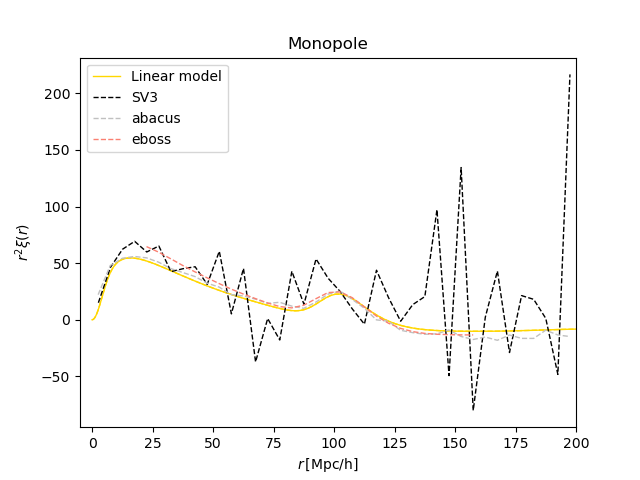

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
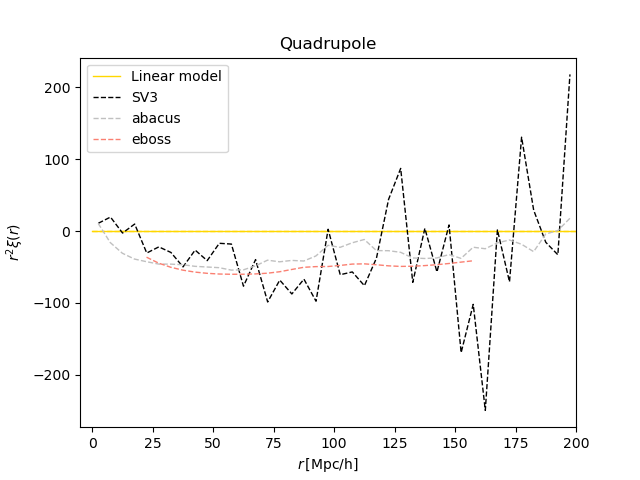

In [12]:
for pole in 0,2:
    fig, ax = plt.subplots()


    Plots.plot_theory(pole, z=1.52, theory=theory_2lpt, ax=ax, rsd=rsd, plot_args=dict(label='Linear model', lw=1, ls='-', c='gold'))
    for survey in [realdata, abacus, eboss]:
        ax.plot(survey.r, survey.r**2*survey.compute_npole(pole), label=str(survey), c=survey.color, ls='--', lw=1)
    # ax.plot(realdata.r, realdata.r**2*realdata.compute_npole(pole), label='SV3', c='k', ls='--', lw=1)
    # ax.plot(abacus.r, abacus.r**2*abacus.compute_npole(pole), c='silver', ls='--', lw=1, label='abacus')
    # ax.plot(eboss.r, eboss.r**2*eboss.compute_npole(pole), c='salmon', ls='--', lw=1, label='eboss')
    ax.legend()
    ax.set_title(pole_string[pole])
    ax.set_xlim(-5, 200)
    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
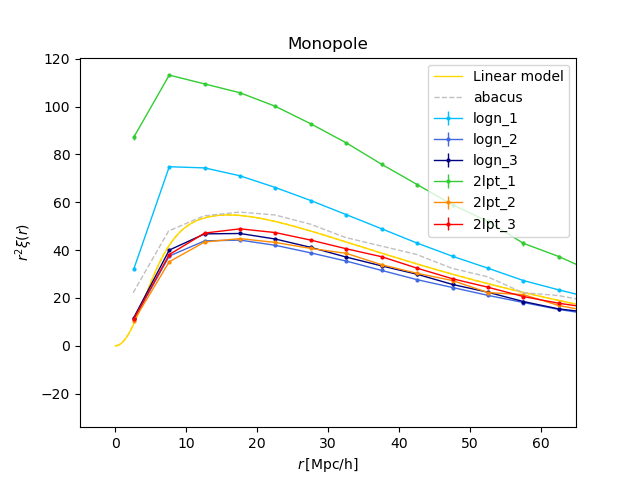

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
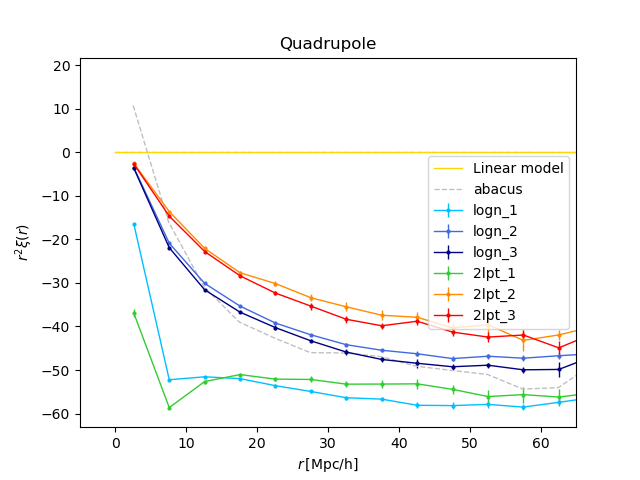

In [13]:
for pole in 0,2:
    fig, ax = plt.subplots()

    for analysis in analyses:
        analysis.z = analysis.theory.get_zeff(zmin, zmax)
        Plots.plot_data(pole, analysis.boxes, ax=ax, plot_args=dict(fmt='-', marker='o', markersize=2, lw=1, c=analysis.color, label=str(analysis)))

    Plots.plot_theory(pole, z=analysis.z, theory=theory_2lpt, ax=ax, rsd=rsd, plot_args=dict(label='Linear model', lw=1, ls='-', c='gold'))
    for survey in [abacus]:
        ax.plot(survey.r, survey.r**2*survey.compute_npole(pole), label=str(survey), c=survey.color, ls='--', lw=1)

    # ax.plot(realdata.r, realdata.r**2*realdata.compute_npole(pole), label='SV3', c='k', ls='--', lw=1)
    # ax.plot(abacus.r, abacus.r**2*abacus.compute_npole(pole), c='silver', ls='--', lw=1, label='abacus')
    # ax.plot(eboss.r, eboss.r**2*eboss.compute_npole(pole), c='salmon', ls='--', lw=1, label='eboss')
    ax.set_title(pole_string[pole])
    ax.legend()
    ax.set_xlim(-5, 65)
    plt.show()

# scale-fit instead of bias

Maybe what seems a "bias" difference can be explained by a normalization or scale factor. I could include this in the fitter class as an extra parameter and play with it.

In [14]:
for analysis in analyses:
    print(analysis.bias_model)
    _bias = analysis.theory.bias(analysis.z)
    analysis.fitter = Fitter(boxes=analysis.boxes, z=analysis.z, theory=analysis.theory, poles=[0], rsd=rsd, smooth_factor0=1, bias0=_bias, rmin={0:50, 2:50}, rmax={0:80, 2:80})
    analysis.fitter.run_fit(free_params=['scale_factor'])

1
2
3
1
2
3


Scaling abacus sims:

In [15]:
from scipy.interpolate import interp1d
from lmfit import minimize, Parameters

In [16]:
def fit_factor(data_r, data_xi, model_r, model_xi, data_xi_err=None, rmin=10):
    model_interp = interp1d(model_r, model_xi)
    params = Parameters()
    params.add('factor', value=1, min=0, vary=True)
    
    mask = data_r > rmin
    data_r = data_r[mask]
    data_xi = data_xi[mask]
    
    def residual(params):
        if data_xi_err is None:
            return params['factor'].value*data_xi - model_interp(data_r)
        else:
            return (params['factor'].value*data_xi-model_interp(data_r))/data_xi_err
        
    return minimize(residual, params)

In [17]:
def get_scale_from_survey(survey, npole):
    data_r = survey.r
    data_xi = survey.compute_npole(npole)
    model_r = theory_2lpt.r
    model_xi = theory_2lpt.get_npole(npole, z=1.52, rsd=True)
    
    out = fit_factor(data_r, data_xi, model_r, model_xi)
    return out

In [18]:
abacus.scale = get_scale_from_survey(abacus, 0).params['factor'].value
eboss.scale = get_scale_from_survey(eboss, 0).params['factor'].value
realdata.scale = get_scale_from_survey(realdata, 0).params['factor'].value

In [19]:
# fig, axs = plt.subplots(ncols=3, nrows=2, sharey=True, figsize=(20,12))
# pole=0

# axs = np.asarray(axs).reshape(-1)
# for ax, analysis in zip(axs, analyses):
#     Plots.plot_data(pole, analysis.boxes, ax=ax, no_labels=True, plot_args=dict(c=analysis.color))
# #     Plots.plot_theory(pole, z=z, theory=theory, ax=ax, rsd=False, no_labels=True)
#     Plots.plot_best_fit(fitter=analysis.fitter, ax=ax, pole=pole, plot_args=dict(c='silver', lw=1), no_labels=True)
#     ax.set_title(analysis.path.name)
#     ax.set_xlim(-5, 200)
    
# fig.supylabel(r'$r^2 \, \xi(r) \, {\rm [(Mpc/h){^2}]}$', x=0.05)
# fig.supxlabel(r'$r \, {\rm [Mpc/h]}$')
# plt.subplots_adjust(wspace=0.1)

In [20]:
%matplotlib widget

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
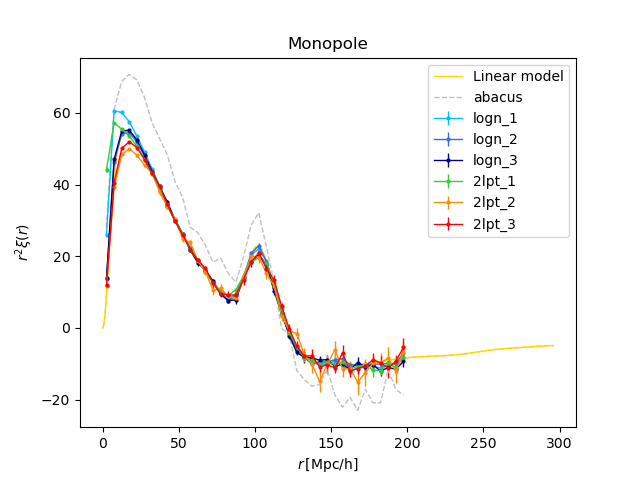

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
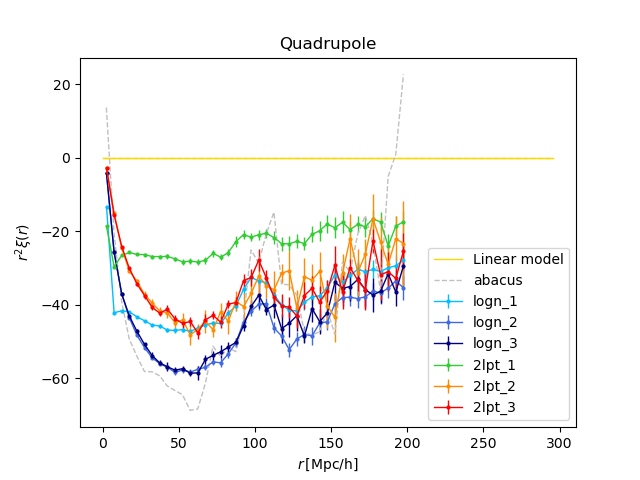

In [21]:
for pole in 0,2:
    fig, ax = plt.subplots()

    for analysis in analyses:
        _xi, _xierr = Plots.get_xi(pole, analysis.boxes)
        _fitter = analysis.fitter
        _r = analysis.boxes[0].savg
        _best_scale = analysis.fitter.out.params['scale_factor'].value
        ax.errorbar(_r, _r**2*_xi/_best_scale, _r**2*_xierr/_best_scale, c=analysis.color, label=str(analysis), fmt='-', marker='o', markersize=2, lw=1,)

    Plots.plot_theory(pole, z=analysis.z, theory=theory_2lpt, ax=ax, rsd=rsd, plot_args=dict(label='Linear model', lw=1, ls='-', c='gold'))
    for survey in (abacus,):
        ax.plot(survey.r, survey.r**2*survey.compute_npole(pole)*survey.scale, c=survey.color, ls='--', lw=1, label=str(survey))
    # ax.plot(realdata.r, realdata.r**2*realdata.compute_npole(pole)*realdata.scale, label='SV3', c='k', ls='--', lw=1)
    # ax.plot(abacus.r, abacus.r**2*abacus.compute_npole(pole)*abacus.scale, c='silver', ls='--', lw=1, label='abacus')
    # ax.plot(eboss.r, eboss.r**2*eboss.compute_npole(pole)*eboss.scale, c='salmon', ls='--', lw=1, label='eboss')

    ax.legend()
    ax.set_title(pole_string[pole])
    #ax.set_xlim(-5, 200)
    # @ put labels!
    plt.show()

# Fit of bias

In [22]:
for analysis in analyses:
    print(analysis.bias_model)
    _bias = analysis.theory.bias(analysis.z)
    analysis.fitter_bias = Fitter(boxes=analysis.boxes, z=analysis.z, theory=analysis.theory, poles=[0], rsd=rsd, smooth_factor0=1, bias0=_bias, rmin={0:30, 2:30}, rmax={0:80, 2:80})
    analysis.fitter_bias.run_fit(free_params=['bias'])

1
2
3
1
2
3


In [23]:
def fit_factor_bias(data_r, data_xi, model, data_xi_err=None, rmin=10, npole=0):
    params = Parameters()
    params.add('bias', value=1, min=0, vary=True)
    
    mask = data_r > rmin
    data_r = data_r[mask]
    data_xi = data_xi[mask]
    
    
    def residual(params):
        model_interp = interp1d(model.r, model.get_npole(npole, z=1.52, rsd=True, bias=params['bias'].value))                                
        if data_xi_err is None:
            return data_xi - model_interp(data_r)
        else:
            return (data_xi-model_interp(data_r))/data_xi_err
        
    return minimize(residual, params)

In [24]:
def get_bias_from_survey(survey, npole):
    data_r = survey.r
    data_xi = survey.compute_npole(npole)
    
    out = fit_factor_bias(data_r, data_xi, theory_2lpt, npole=npole)
    return out

In [25]:
for _survey in eboss, realdata, abacus:
    _survey.best_bias = get_bias_from_survey(_survey, 0).params['bias'].value
    print(_survey.label, _survey.best_bias)

eboss 2.2994835360858388
SV3 2.2420603294433246
abacus 2.055341964942319


In [26]:
for analysis in analyses:
    print(analysis.label)
    print(analysis.fitter_bias.out.params['bias'].value)

logn_1
2.643580586490278
logn_2
2.127041972172627
logn_3
2.184162782016047
2lpt_1
3.3034430913126815
2lpt_2
2.2237617584232714
2lpt_3
2.2909559923037794


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
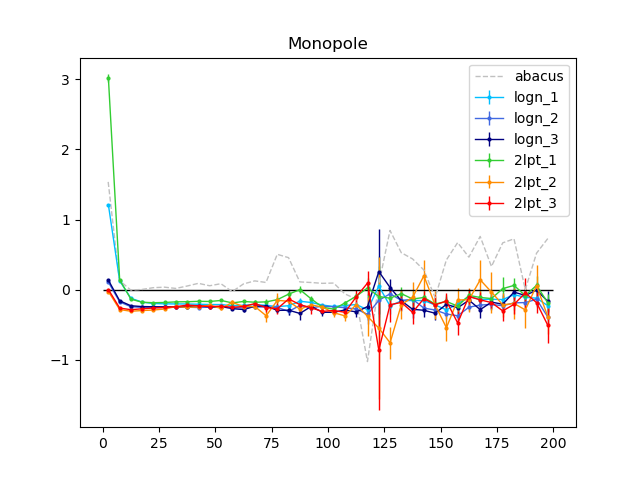

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
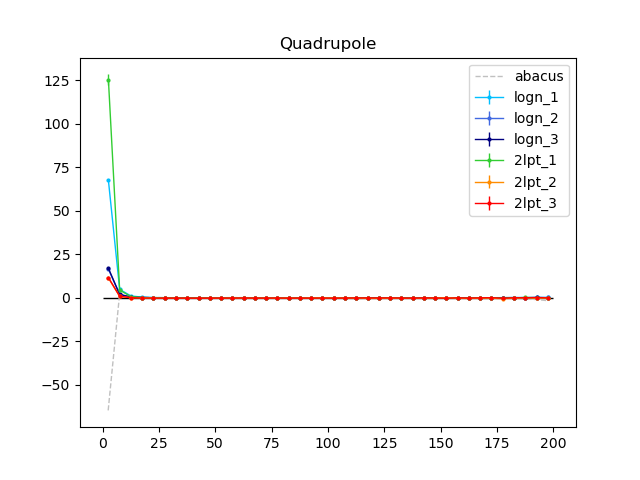

In [27]:
for pole in 0,2:
    fig, ax = plt.subplots()

    for analysis in analyses:
        _xi, _xierr = Plots.get_xi(pole, analysis.boxes)
        _r = analysis.boxes[0].savg
        _rth = theory_2lpt.r
        _xith = theory_2lpt.get_npole(pole, z=1.52, rsd=True, bias = analysis.fitter_bias.out.params['bias'].value)

        thinterp = interp1d(_rth, _xith)
        _xithinterp = thinterp(_r)
        ax.errorbar(_r, _xi/_xithinterp-1, _xierr/_xithinterp, c=analysis.color, label=str(analysis), fmt='-', marker='o', markersize=2, lw=1,)

    for _survey in [abacus,]:
        _r = _survey.r
        _xi = survey.compute_npole(pole)
        _rth = theory_2lpt.r
        _xith = theory_2lpt.get_npole(pole, z=1.52, rsd=True, bias=_survey.best_bias)    

        thinterp = interp1d(_rth, _xith)
        _xithinterp = thinterp(_r)
        ax.plot(_survey.r, _xi/_xithinterp-1, c=survey.color, ls='--', lw=1, label=str(survey))
        ax.hlines(0, 0, 200, lw=1, color='k')
    ax.legend()
    ax.set_title(pole_string[pole])

In [28]:
from CoLoRe_corrf_analysis.plot_methods import Plots
from CoLoRe_corrf_analysis.file_funcs import FileFuncs
from CoLoRe_corrf_analysis.fitter import Fitter
from CoLoRe_corrf_analysis.cf_helper import CFComputations
from CoLoRe_corrf_analysis.read_colore import ComputeModelsCoLoRe

from scipy.interpolate import interp1d
from scipy import ndimage

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [31]:
corrf_files = Path('/global/cscratch1/sd/cramirez/QSO_clustering_analysis/corrf_from_cat')
colore_boxes = corrf_files.parent / 'CoLoRe_boxes'

In [32]:
theory_path = colore_boxes / 'high_3x2_600'
assert theory_path.is_dir()

theory = ComputeModelsCoLoRe(
    box_path=theory_path,
    source=1,
    apply_lognormal=True)

theory_2lpt = ComputeModelsCoLoRe(
    box_path=theory_path,
    source=1,
    apply_lognormal=False)

In [33]:
theory_2lpt.bias(1.52)

array(2.3548058)

In [34]:
zmin = 0.8
zmax = 2.1 
rsd = True

In [35]:
def get_boxes(path, rsd=True, rmin=0.1, rmax=200, N_bins=41, zmin=zmin, zmax=zmax, nside=2):
    return FileFuncs.mix_sims(
        FileFuncs.get_full_path(path,
                                rsd=rsd, rsd2=None, 
                                rmin=rmin, rmax=rmax, N_bins=N_bins,
                                zmin=zmin, zmax=zmax, nside=2)
    )

In [36]:
class NotebookHelper:
    def __str__(self):
        return self.label

analyses = []

_ = NotebookHelper()
_.path = corrf_files / 'high_3x2_600'
_.label = 'logn_1'
_.bias_model = 1
_.dens_type = 0
_.boxes = get_boxes(_.path)
_.theory = theory_2lpt
_.color = 'deepskyblue'
analyses.append(_)

_ = NotebookHelper()
_.path = corrf_files / 'high_3x2_600_bias2'
_.label = 'logn_2'
_.bias_model = 2
_.dens_type = 0
_.boxes = get_boxes(_.path)
_.theory = theory_2lpt
_.color = 'royalblue'
analyses.append(_)

_ = NotebookHelper()
_.path = corrf_files / 'high_3x2_600_bias3'
_.label = 'logn_3'
_.bias_model = 3
_.dens_type = 0
_.boxes = get_boxes(_.path)
_.theory = theory_2lpt
_.color = 'navy'
analyses.append(_)

# 2LPT FIELDS (WHENEVER THEY ARE READY)
_ = NotebookHelper()
_.path = corrf_files / 'high_3x2_600_2lpt'
_.label = '2lpt_1'
_.bias_model = 1
_.dens_type = 0
_.boxes = get_boxes(_.path)
_.theory = theory_2lpt
_.color = 'limegreen'
analyses.append(_)

_ = NotebookHelper()
_.path = corrf_files / 'high_3x2_600_2lpt_bias2'
_.label = '2lpt_2'
_.bias_model = 2
_.dens_type = 0
_.boxes = get_boxes(_.path)
_.theory = theory_2lpt
_.color = 'darkorange'
analyses.append(_)

_ = NotebookHelper()
_.path = corrf_files / 'high_3x2_600_2lpt_bias3'
_.label = '2lpt_3'
_.bias_model = 3
_.dens_type = 0
_.boxes = get_boxes(_.path)
_.theory = theory_2lpt
_.color = 'red'
analyses.append(_)

class RealDataHelper:
    def smoothed_npole(self, pole, sigma=1):
        _r = self.boxes[0].savg
        npole = self.boxes[0].compute_npole(pole)
        _smoothed_r2_npole =  ndimage.gaussian_filter1d(_r**2*npole, sigma)
        return _smoothed_r2_npole/_r**2
    
    @property
    def r(self):
        return self.boxes[0].savg
    
    def compute_npole(self, pole):
        return self.boxes[0].compute_npole(pole)
    
    def __str__(self):
        return self.label
        
realdata = RealDataHelper()
realdata.path = Path('/global/cscratch1/sd/cramirez/QSO_clustering_analysis/corrf_real_data/')
realdata.bias_model = None
realdata.dens_type = None
realdata.boxes = [CFComputations(Path('/global/cscratch1/sd/cramirez/QSO_clustering_analysis/corrf_real_data/nside_0/rsd/0.1_200_41/0.8_2.1/0/0'))]
realdata.theory = theory_2lpt
realdata.color = 'k'
realdata.label = 'SV3'

class AbacusOut:
    def __init__(self, path):
        self.path = Path
        self.npoles = dict()
        try:
            r, _0, _2, _4 = np.loadtxt(path, unpack=True)
            self.npoles[0] = _0 
            self.npoles[2] = _2
            self.npoles[4] = _4
        except ValueError:
            r, _0 = np.loadtxt(path, unpack=True)
            self.npoles[0] = _0
            self.npoles[2] = np.zeros_like(_0)
            self.npoles[4] = np.zeros_like(_0)
        
        self.r = r
        
    def compute_npole(self, pole):
        return self.npoles[pole]
    
    def __str__(self):
        return self.label

abacus = AbacusOut('/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/Clustering/CubicBox/QSO/AbacusSummit_base_c000/z1.400/2PCF/2PCF_QSO_snap12_ph024.gcat_RSD.dat')
abacus.color = 'silver'
abacus.label = 'abacus'

class eBossModel:
    def __init__(self, file):
        self.file = file
        _s, _xi0, _xi2, _xi4 = np.loadtxt(self.file, unpack=True)
        self.r = _s
        self.poles = {0: _xi0, 2: _xi2, 4: _xi4}
    
    def compute_npole(self, pole):
        return self.poles[pole]

    def __str__(self):
        return self.label    
    
eboss = eBossModel('../eBOSS_data/Model_QSOxi_NGCSGC_0.8z2.2_prerecon.txt')
eboss.color = 'salmon'
eboss.label = 'eboss'

for analysis in analyses:
    assert analysis.path.is_dir()

In [37]:
pole_string = {0: 'Monopole', 2: 'Quadrupole'}

In [38]:
%matplotlib widget

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
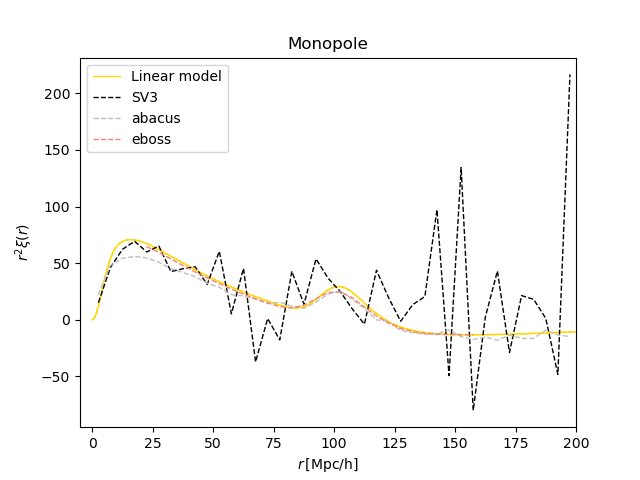

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
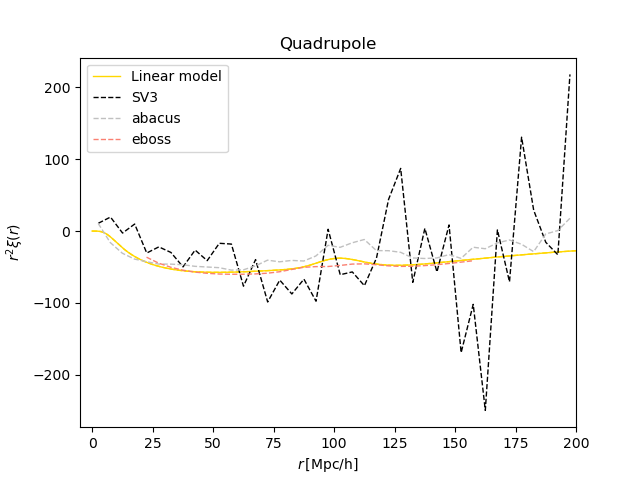

In [39]:
for pole in 0,2:
    fig, ax = plt.subplots()


    Plots.plot_theory(pole, z=1.52, theory=theory_2lpt, ax=ax, rsd=rsd, plot_args=dict(label='Linear model', lw=1, ls='-', c='gold'))
    for survey in [realdata, abacus, eboss]:
        ax.plot(survey.r, survey.r**2*survey.compute_npole(pole), label=str(survey), c=survey.color, ls='--', lw=1)
    # ax.plot(realdata.r, realdata.r**2*realdata.compute_npole(pole), label='SV3', c='k', ls='--', lw=1)
    # ax.plot(abacus.r, abacus.r**2*abacus.compute_npole(pole), c='silver', ls='--', lw=1, label='abacus')
    # ax.plot(eboss.r, eboss.r**2*eboss.compute_npole(pole), c='salmon', ls='--', lw=1, label='eboss')
    ax.legend()
    ax.set_title(pole_string[pole])
    ax.set_xlim(-5, 200)
    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
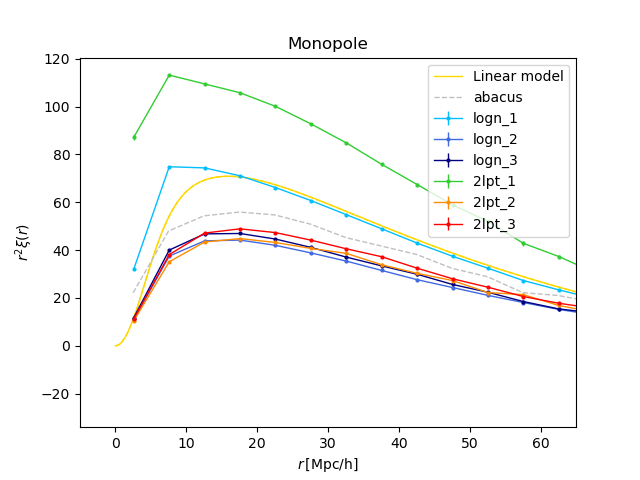

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
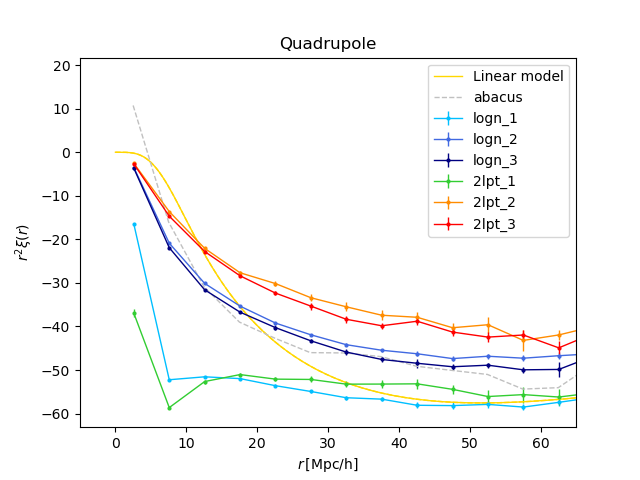

In [40]:
for pole in 0,2:
    fig, ax = plt.subplots()

    for analysis in analyses:
        analysis.z = analysis.theory.get_zeff(zmin, zmax)
        Plots.plot_data(pole, analysis.boxes, ax=ax, plot_args=dict(fmt='-', marker='o', markersize=2, lw=1, c=analysis.color, label=str(analysis)))

    Plots.plot_theory(pole, z=analysis.z, theory=theory_2lpt, ax=ax, rsd=rsd, plot_args=dict(label='Linear model', lw=1, ls='-', c='gold'))
    for survey in [abacus]:
        ax.plot(survey.r, survey.r**2*survey.compute_npole(pole), label=str(survey), c=survey.color, ls='--', lw=1)

    # ax.plot(realdata.r, realdata.r**2*realdata.compute_npole(pole), label='SV3', c='k', ls='--', lw=1)
    # ax.plot(abacus.r, abacus.r**2*abacus.compute_npole(pole), c='silver', ls='--', lw=1, label='abacus')
    # ax.plot(eboss.r, eboss.r**2*eboss.compute_npole(pole), c='salmon', ls='--', lw=1, label='eboss')
    ax.set_title(pole_string[pole])
    ax.legend()
    ax.set_xlim(-5, 65)
    plt.show()

# scale-fit instead of bias

Maybe what seems a "bias" difference can be explained by a normalization or scale factor. I could include this in the fitter class as an extra parameter and play with it.

In [41]:
for analysis in analyses:
    print(analysis.bias_model)
    _bias = analysis.theory.bias(analysis.z)
    analysis.fitter = Fitter(boxes=analysis.boxes, z=analysis.z, theory=analysis.theory, poles=[0], rsd=rsd, smooth_factor0=1, bias0=_bias, rmin={0:50, 2:50}, rmax={0:80, 2:80})
    analysis.fitter.run_fit(free_params=['scale_factor'])

1
2
3
1
2
3


Scaling abacus sims:

In [42]:
from scipy.interpolate import interp1d
from lmfit import minimize, Parameters

In [43]:
def fit_factor(data_r, data_xi, model_r, model_xi, data_xi_err=None, rmin=10):
    model_interp = interp1d(model_r, model_xi)
    params = Parameters()
    params.add('factor', value=1, min=0, vary=True)
    
    mask = data_r > rmin
    data_r = data_r[mask]
    data_xi = data_xi[mask]
    
    def residual(params):
        if data_xi_err is None:
            return params['factor'].value*data_xi - model_interp(data_r)
        else:
            return (params['factor'].value*data_xi-model_interp(data_r))/data_xi_err
        
    return minimize(residual, params)

In [44]:
def get_scale_from_survey(survey, npole):
    data_r = survey.r
    data_xi = survey.compute_npole(npole)
    model_r = theory_2lpt.r
    model_xi = theory_2lpt.get_npole(npole, z=1.52, rsd=True)
    
    out = fit_factor(data_r, data_xi, model_r, model_xi)
    return out

In [45]:
abacus.scale = get_scale_from_survey(abacus, 0).params['factor'].value
eboss.scale = get_scale_from_survey(eboss, 0).params['factor'].value
realdata.scale = get_scale_from_survey(realdata, 0).params['factor'].value

In [46]:
# fig, axs = plt.subplots(ncols=3, nrows=2, sharey=True, figsize=(20,12))
# pole=0

# axs = np.asarray(axs).reshape(-1)
# for ax, analysis in zip(axs, analyses):
#     Plots.plot_data(pole, analysis.boxes, ax=ax, no_labels=True, plot_args=dict(c=analysis.color))
# #     Plots.plot_theory(pole, z=z, theory=theory, ax=ax, rsd=False, no_labels=True)
#     Plots.plot_best_fit(fitter=analysis.fitter, ax=ax, pole=pole, plot_args=dict(c='silver', lw=1), no_labels=True)
#     ax.set_title(analysis.path.name)
#     ax.set_xlim(-5, 200)
    
# fig.supylabel(r'$r^2 \, \xi(r) \, {\rm [(Mpc/h){^2}]}$', x=0.05)
# fig.supxlabel(r'$r \, {\rm [Mpc/h]}$')
# plt.subplots_adjust(wspace=0.1)

In [47]:
%matplotlib widget

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
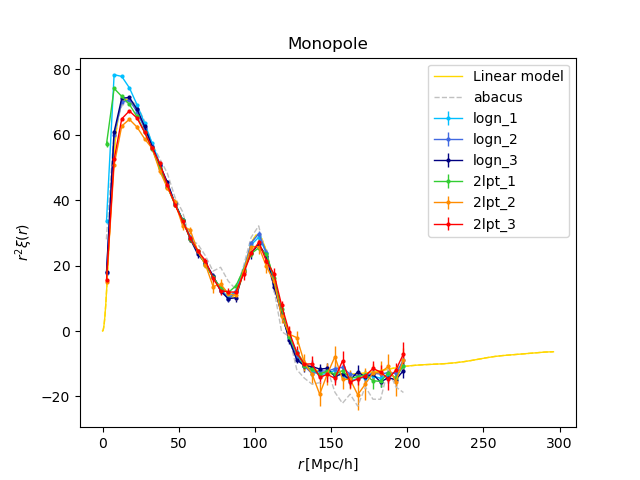

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
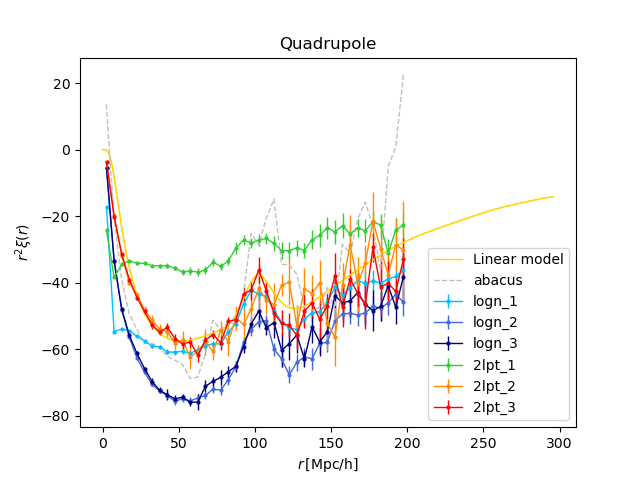

In [48]:
for pole in 0,2:
    fig, ax = plt.subplots()

    for analysis in analyses:
        _xi, _xierr = Plots.get_xi(pole, analysis.boxes)
        _fitter = analysis.fitter
        _r = analysis.boxes[0].savg
        _best_scale = analysis.fitter.out.params['scale_factor'].value
        ax.errorbar(_r, _r**2*_xi/_best_scale, _r**2*_xierr/_best_scale, c=analysis.color, label=str(analysis), fmt='-', marker='o', markersize=2, lw=1,)

    Plots.plot_theory(pole, z=analysis.z, theory=theory_2lpt, ax=ax, rsd=rsd, plot_args=dict(label='Linear model', lw=1, ls='-', c='gold'))
    for survey in (abacus,):
        ax.plot(survey.r, survey.r**2*survey.compute_npole(pole)*survey.scale, c=survey.color, ls='--', lw=1, label=str(survey))
    # ax.plot(realdata.r, realdata.r**2*realdata.compute_npole(pole)*realdata.scale, label='SV3', c='k', ls='--', lw=1)
    # ax.plot(abacus.r, abacus.r**2*abacus.compute_npole(pole)*abacus.scale, c='silver', ls='--', lw=1, label='abacus')
    # ax.plot(eboss.r, eboss.r**2*eboss.compute_npole(pole)*eboss.scale, c='salmon', ls='--', lw=1, label='eboss')

    ax.legend()
    ax.set_title(pole_string[pole])
    #ax.set_xlim(-5, 200)
    # @ put labels!
    plt.show()

# Fit of bias

In [49]:
for analysis in analyses:
    print(analysis.bias_model)
    _bias = analysis.theory.bias(analysis.z)
    analysis.fitter_bias = Fitter(boxes=analysis.boxes, z=analysis.z, theory=analysis.theory, poles=[0], rsd=rsd, smooth_factor0=1, bias0=_bias, rmin={0:30, 2:30}, rmax={0:80, 2:80})
    analysis.fitter_bias.run_fit(free_params=['bias'])

1
2
3
1
2
3


In [50]:
def fit_factor_bias(data_r, data_xi, model, data_xi_err=None, rmin=10, npole=0):
    params = Parameters()
    params.add('bias', value=1, min=0, vary=True)
    
    mask = data_r > rmin
    data_r = data_r[mask]
    data_xi = data_xi[mask]
    
    
    def residual(params):
        model_interp = interp1d(model.r, model.get_npole(npole, z=1.52, rsd=True, bias=params['bias'].value))                                
        if data_xi_err is None:
            return data_xi - model_interp(data_r)
        else:
            return (data_xi-model_interp(data_r))/data_xi_err
        
    return minimize(residual, params)

In [51]:
def get_bias_from_survey(survey, npole):
    data_r = survey.r
    data_xi = survey.compute_npole(npole)
    
    out = fit_factor_bias(data_r, data_xi, theory_2lpt, npole=npole)
    return out

In [52]:
for _survey in eboss, realdata, abacus:
    _survey.best_bias = get_bias_from_survey(_survey, 0).params['bias'].value
    print(_survey.label, _survey.best_bias)

eboss 2.2994835360858388
SV3 2.2420603294433246
abacus 2.055341964942319


In [53]:
for analysis in analyses:
    print(analysis.label)
    print(analysis.fitter_bias.out.params['bias'].value)

logn_1
2.317580575434859
logn_2
1.797453006252821
logn_3
1.8550746221096568
2lpt_1
2.9803640944240604
2lpt_2
1.8949866860779436
2lpt_3
1.9626940452211028


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
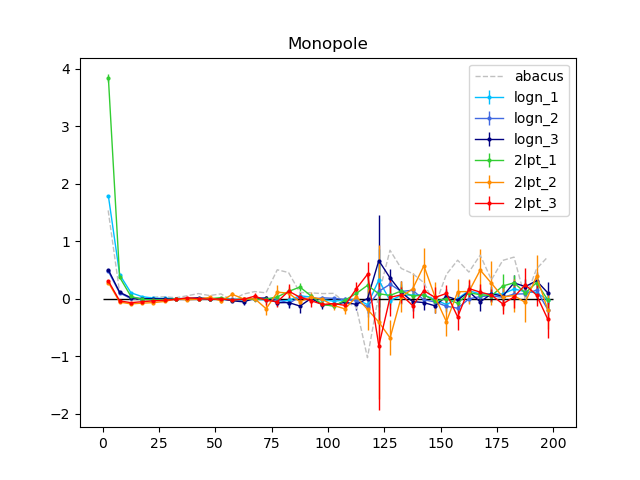

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
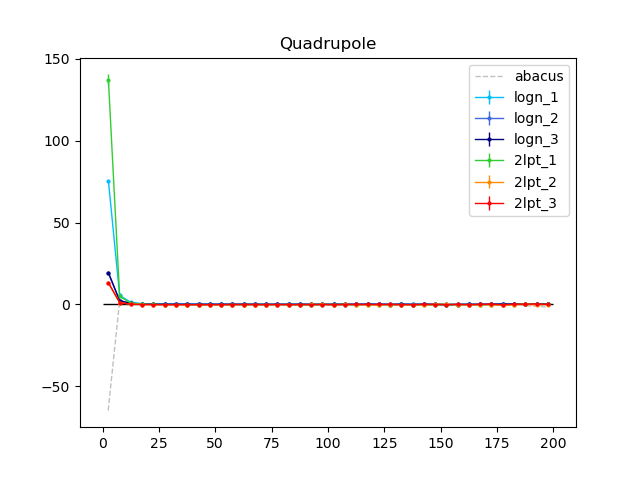

In [54]:
for pole in 0,2:
    fig, ax = plt.subplots()

    for analysis in analyses:
        _xi, _xierr = Plots.get_xi(pole, analysis.boxes)
        _r = analysis.boxes[0].savg
        _rth = theory_2lpt.r
        _xith = theory_2lpt.get_npole(pole, z=1.52, rsd=True, bias = analysis.fitter_bias.out.params['bias'].value)

        thinterp = interp1d(_rth, _xith)
        _xithinterp = thinterp(_r)
        ax.errorbar(_r, _xi/_xithinterp-1, _xierr/_xithinterp, c=analysis.color, label=str(analysis), fmt='-', marker='o', markersize=2, lw=1,)

    for _survey in [abacus,]:
        _r = _survey.r
        _xi = survey.compute_npole(pole)
        _rth = theory_2lpt.r
        _xith = theory_2lpt.get_npole(pole, z=1.52, rsd=True, bias=_survey.best_bias)    

        thinterp = interp1d(_rth, _xith)
        _xithinterp = thinterp(_r)
        ax.plot(_survey.r, _xi/_xithinterp-1, c=survey.color, ls='--', lw=1, label=str(survey))
        ax.hlines(0, 0, 200, lw=1, color='k')
    ax.legend()
    ax.set_title(pole_string[pole])